In [1]:
%%time 
%reload_ext autoreload
%autoreload 2
from utils.model import *
from utils.helpers import *
from utils.imports import *

# instantiate model
model = DecoderModel(vocab_size)
model = model.to(device) # move model parameters to gpu if available

# load val_data by crawling the list of wiki pages in "dataset/val_wiki.json"
val_data, val_urls = load_val_data(num_pages=10)
train_data, num_chars = crawl_wiki_data(new_links, visited_urls, num_chars, add=1e6, printer=True)


CUDA_VISIBLE_DEVICES = 7
device: cuda

num_params: 85M
d_model: 768
n_layer: 12
n_heads:  12
d_head:  64
block_size:  1024
batch_size: 12
learning_rate:  0.0003

crawl_wiki_data: add=1.00M characters... page_length:128.3K, len(new_links):1605, len(visited_urls):11, num_chars:128.28K  https://www.wikipedia.org/wiki/David_Bowie                                                                      
page_length: 29.3K, len(new_links):1706, len(visited_urls):12, num_chars:157.55K  https://www.wikipedia.org/wiki/Kouroi                                                                      
page_length:  4.8K, len(new_links):1802, len(visited_urls):13, num_chars:162.36K  https://www.wikipedia.org/wiki/The_Big_One_(film)                                                                      
page_length: 33.7K, len(new_links):2010, len(visited_urls):14, num_chars:196.03K  https://www.wikipedia.org/wiki/Charles_Mingus                                                                      
page_length:

In [2]:
%%time
step = 0

# Create a pytorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)  # usually 3e-4 for bigger networks.

list_epochs, list_losses, list_epochs_eval, list_losses_eval = [0], [], [0], [] 

xb, yb, pivot = get_batch(train_data, batch_size, pivot=0)

logits, loss = model(xb, yb)
print()
if device.startswith('cuda') and torch.cuda.device_count() > 1:
    loss = np.mean(loss.tolist())
list_losses.append(loss.tolist())
losses = estimate_loss(model, train_data, val_data, 0, time.time())

list_losses_eval.append([item.detach().numpy().tolist() for item in (losses['train'], losses['val'])])

print(f'logits.shape (block_size * batch_size) = {logits.shape}')
print(f'loss: {loss:.3f}')
# generate_text(model, step, time.time());



estimating loss...
step 0:    train_loss:4.7934, val_loss:4.7858  (...Runtime: 2 min 12 sec)
logits.shape (block_size * batch_size) = torch.Size([12288, 97])
loss: 4.803
CPU times: user 1min 48s, sys: 31.4 s, total: 2min 19s
Wall time: 2min 13s


In [3]:
# train loop
start = time.time()

while step < max_iters:
    step += 1
    epoch = step * batch_size * block_size  # epoch is num of tokens ingested.
    sample_no = step * batch_size 

    # sample a batch of data
    xb, yb, pivot = get_batch(train_data, batch_size, pivot)
    while len(xb) < batch_size:
        repo_xb, repo_yb, pivot = xb, yb, 0
        train_data, num_chars = crawl_wiki_data(new_links, visited_urls, num_chars, add, printer=False)
        xb, yb, pivot = get_batch(train_data, batch_size-len(xb), pivot)
        xb = torch.cat((repo_xb, xb))
        yb = torch.cat((repo_yb, yb))

    # evaluate the loss
    logits, loss = model(xb, yb)
    if device.startswith('cuda') and torch.cuda.device_count() > 1:
        # averages multi-GPU losses
        loss = loss.mean()
    optimizer.zero_grad(set_to_none=True)
    loss.backward() # get the gradients with backprop.
    optimizer.step() # apply the gradient on the parameters

    list_losses.append(loss.item())
    list_epochs.append(sample_no)

    # evaluate at fixed intervals
    if sample_no % eval_interval == 0 or step == max_iters:
        losses = estimate_loss(model, train_data, val_data, step, start)
        list_epochs_eval.append(sample_no)
        list_losses_eval.append([item.detach().numpy().tolist() for item in (losses['train'], losses['val'])])
        plotter(list_epochs, list_losses, list_epochs_eval, list_losses_eval, step)
        
    if sample_no % (eval_interval * 4) == 0:
        generate_text(model, step, start)

    if step % 10 == 0: 
        print(f'step:{step:3d}  {print_runtime(start, False)}')


RuntimeError: CUDA out of memory. Tried to allocate 144.00 MiB (GPU 0; 31.72 GiB total capacity; 24.63 GiB already allocated; 56.88 MiB free; 24.86 GiB reserved in total by PyTorch)

device: cuda


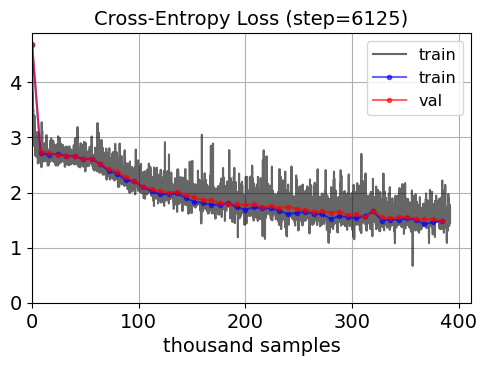

step:6125   (...Runtime: 260 min 17 sec)
===>  Text Generation: 
Aayi). Alfter Guyle, the normation is not that Bozs, and not direct developned by the season Brosston and Adelka, Riman and Shahan's has headed, the restluct of his texts section, 2012, following that he was spoken for the pin somebombassywhat the text Buddha. There the best of Keahan (unities by the comApplication pin't foundation of he was premiered as a superindumber of the Sha'd; a like texts o
Runtime: 0 min 17 sec
------------------------------------------------------------------------------------------


In [26]:
plotter(list_epochs, list_losses, list_epochs_eval, list_losses_eval, step)
print(f'step:{step:3d}  {print_runtime(start, False)}')
# model.print_hyperparams_to_stdout()
generate_text(model, step, time.time())


# todo 
- Check if we're doing DDP across 8 GPUs correctly.
- check if `batch_size` designates number of batches per each GPU or the total batches of 8 GPUs.
- ~`get_batches` should get partial batches if it runs out of sentences~
- `get_batches` should process one wiki page at a time. 
- Use `tiktoken` tokenizer


# The Mathematical Trick in Self-Attention

- Attention is a **communication mechanism**. It's anodes in a graph looking at each other and aggregating informtaion with a weighted sum from all nodes pointing to them  

- No notion of space. Attention itself only acts over nodes and vectors.

- Separate batches don't talk to each other. Each example across batch dimension is processed independently. 

- **Encoder:**  No masking with `tril` allowing all tokens to communicate. **Decoder** uses masking in an autoregressive settings so past tokens don't talk to future tokens --otherwise they would give away the answer.

- **Self-Attention:** keys, queries and values arecome from the same source. 
- **Cross-Attention:** queries are produced from x, keys and values are produced from a previous encoder module. Encoder encodes some context we want the decoder's generation process to be conditioned on.
- **Scaling by sqrt(d):** It's an important normalization to have. 


----
## 1. Experiments

In [7]:
block_size = 10
def get_batch_at_random(data, batch_size):
    """ gets batches at random.
    """

    ix = torch.randint(len(data) - block_size, (batch_size,))
    xb = torch.stack([data[i:i+block_size] for i in ix])
    yb = torch.stack([data[i+1:i+block_size+1] for i in ix])
    xb, yb = xb.to(device), yb.to(device)  # move data to gpu if available

    return xb, yb


class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, 100)
        
    def forward(self, idx, targets):
        logits = self.token_embedding_table(idx)  # (B,T,C)
        
        B,T,C = logits.shape
        logits = logits.view(B*T, C)
        
        B,T = targets.shape
        targets = targets.view(B*T)
        
        loss = F.cross_entropy(logits, targets) # cross_entropy wants (B*T,C)
        return logits, loss
        
m = BigramLanguageModel(vocab_size)
m.to(device)

BigramLanguageModel(
  (token_embedding_table): Embedding(97, 100)
)

In [14]:
xb, yb = get_batch_at_random(train_data, batch_size=4)
print(xb.shape)
logits, loss = m(xb, yb)
loss

torch.Size([4, 10])


tensor(4.8667, device='cuda:0', grad_fn=<NllLossBackward>)

In [16]:
logits = m.token_embedding_table(xb) # (B,T,C)

print(logits.shape)
B,T,C = logits.shape
logits = logits.view(B*T, C)

print(logits.shape)

logits

torch.Size([4, 10, 100])
torch.Size([40, 100])


tensor([[-0.4313,  0.7174,  0.8237,  ...,  0.0455,  0.7355,  0.2423],
        [ 2.2760, -0.2209, -1.0450,  ...,  0.3008, -0.7989, -0.2984],
        [ 0.5670, -0.6300, -0.4114,  ..., -0.7038,  0.5539, -0.5832],
        ...,
        [-1.1034,  1.3797,  0.7322,  ...,  2.4419,  0.3631,  1.1233],
        [-0.4236,  1.2271,  0.5769,  ...,  0.3366, -0.5202, -1.3891],
        [ 1.1046, -0.4197,  1.5307,  ..., -0.9014,  0.4311,  2.6972]],
       device='cuda:0', grad_fn=<ViewBackward>)

## 2. Experiments
---

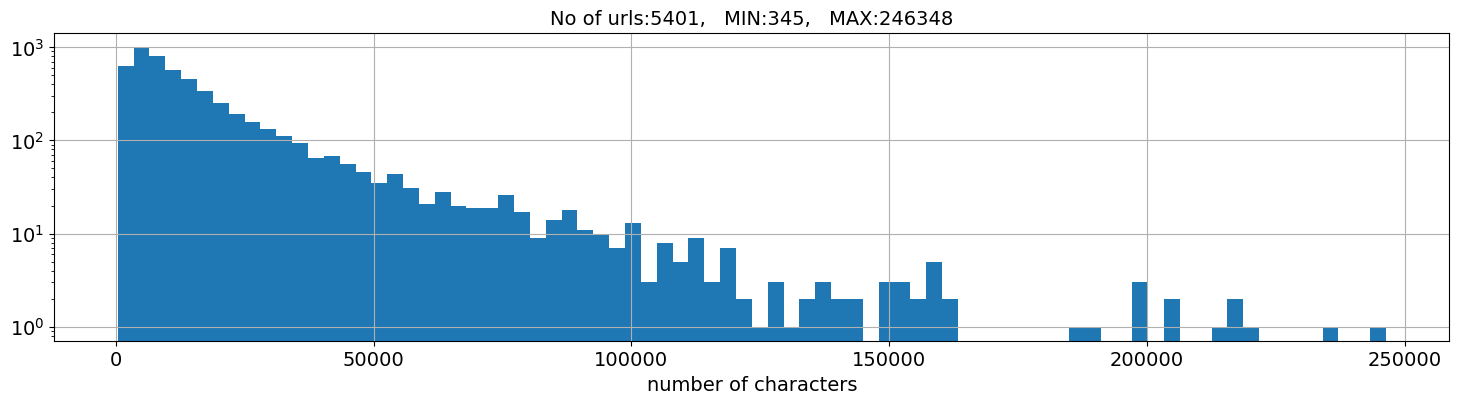

In [2]:
dirname='dataset/repo_wiki/'
fnames = sorted(glob.glob(f'{dirname}/*pkl'))
wikis = dict()
for fname in fnames:
    with open(fname, 'rb') as f:
        wikis.update(pickle.load(f)) 

urls = list(wikis.keys())
out = [(len(wikis[url])) for url in (urls)]
x, y, patches  = plt.hist(out, bins=80, log=True); plt.xlabel('number of characters'); 
plt.title(f'No of urls:{len(urls)},   MIN:{min(out)},   MAX:{max(out)}');


/data/home/osafak/.conda/envs/pt_env/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 9 (	) missing from current font.
  func(*args, **kwargs)
/data/home/osafak/.conda/envs/pt_env/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


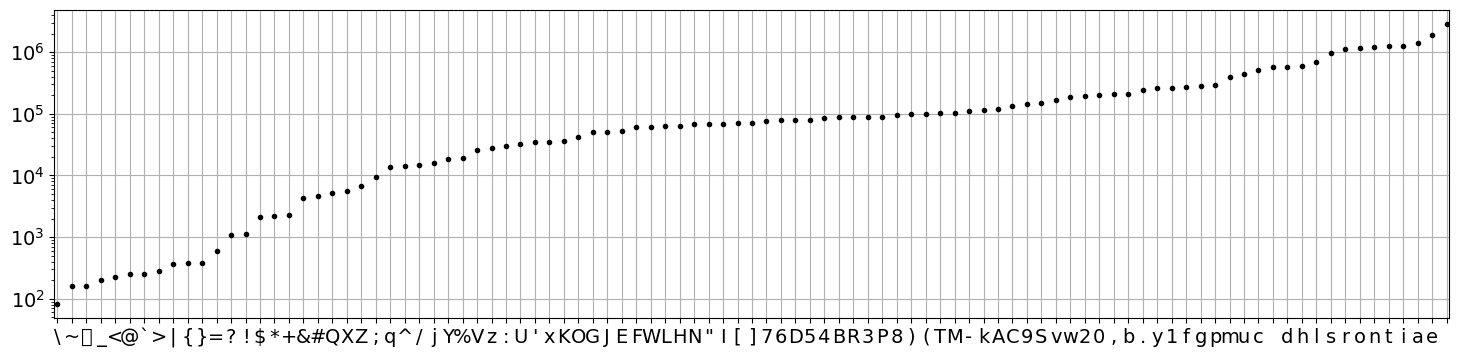

In [3]:
cnt = plot_character_frequency(urls[:1000], wikis)